# 🩺 Diabetes Prediction — End-to-End ML Notebook
**Dataset:** [Pima Indians Diabetes Dataset](https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv)  
**Model:** Random Forest Classifier  
**Goal:** Predict whether a patient has diabetes based on diagnostic measurements.

---
## Table of Contents
1. Import Libraries
2. Load & Inspect Data
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing
5. Feature Engineering
6. Model Building — Random Forest
7. Hyperparameter Tuning
8. Model Evaluation
9. Feature Importance
10. Conclusion

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer

# Plot style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120

print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 2. Load & Inspect Data

In [2]:
URL = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
df = pd.read_csv(URL)

print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print('=== Data Types & Non-null Counts ===')
df.info()

=== Data Types & Non-null Counts ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
print('=== Descriptive Statistics ===')
df.describe().T.style.background_gradient(cmap='Blues')

=== Descriptive Statistics ===


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


In [5]:
print('=== Target Variable Distribution ===')
print(df['Outcome'].value_counts())
print(f"\nDiabetes prevalence: {df['Outcome'].mean()*100:.1f}%")

=== Target Variable Distribution ===
Outcome
0    500
1    268
Name: count, dtype: int64

Diabetes prevalence: 34.9%


## 3. Exploratory Data Analysis (EDA)

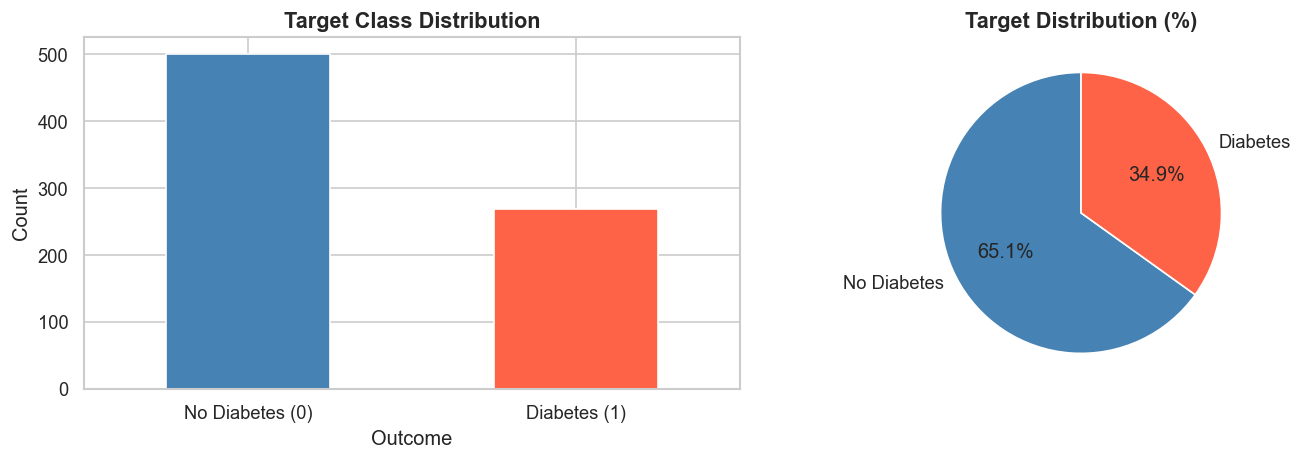

In [6]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Outcome'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'tomato'], edgecolor='white', width=0.5)
axes[0].set_title('Target Class Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'], rotation=0)
axes[0].set_ylabel('Count')

df['Outcome'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                   colors=['steelblue', 'tomato'], startangle=90,
                                   labels=['No Diabetes', 'Diabetes'])
axes[1].set_title('Target Distribution (%)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Feature distributions by Outcome
features = [c for c in df.columns if c != 'Outcome']
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, feat in enumerate(features):
    df[df['Outcome'] == 0][feat].hist(ax=axes[i], alpha=0.6, color='steelblue', label='No Diabetes', bins=20)
    df[df['Outcome'] == 1][feat].hist(ax=axes[i], alpha=0.6, color='tomato', label='Diabetes', bins=20)
    axes[i].set_title(feat, fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].set_xlabel('')

plt.suptitle('Feature Distributions by Diabetes Outcome', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 7))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Boxplots to detect outliers
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, feat in enumerate(features):
    df.boxplot(column=feat, by='Outcome', ax=axes[i],
               boxprops=dict(color='steelblue'),
               medianprops=dict(color='tomato', linewidth=2))
    axes[i].set_title(feat, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Outcome (0=No, 1=Yes)')

plt.suptitle('Feature Boxplots by Diabetes Outcome', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

> **Note:** In this dataset, `0` values in columns like `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` are biologically implausible and represent **missing data**. We'll replace them with `NaN` and impute.

In [7]:
# Replace 0s with NaN for biologically invalid columns
zero_not_allowed = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_clean = df.copy()
df_clean[zero_not_allowed] = df_clean[zero_not_allowed].replace(0, np.nan)

print('Missing values after replacing 0s:')
missing = df_clean.isnull().sum()
missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct.round(1)}).query('`Missing Count` > 0')

Missing values after replacing 0s:


,Missing Count,Missing %
Glucose,5,0.7
BloodPressure,35,4.6
SkinThickness,227,29.6
Insulin,374,48.7
BMI,11,1.4


In [8]:
# Impute missing values with median (robust to outliers)
imputer = SimpleImputer(strategy='median')
df_clean[zero_not_allowed] = imputer.fit_transform(df_clean[zero_not_allowed])

print(f'Remaining missing values: {df_clean.isnull().sum().sum()}')
print('✅ Imputation complete!')

Remaining missing values: 0
✅ Imputation complete!


## 5. Feature Engineering

In [9]:
# Add meaningful derived features
df_clean['BMI_Age'] = df_clean['BMI'] * df_clean['Age']           # Interaction: obesity + age
df_clean['Glucose_Insulin'] = df_clean['Glucose'] / (df_clean['Insulin'] + 1)  # Glucose-Insulin ratio
df_clean['BP_Category'] = pd.cut(df_clean['BloodPressure'],
                                   bins=[0, 80, 90, 200],
                                   labels=[0, 1, 2]).astype(float)  # Normal / High-Normal / Hypertensive

print(f'Features after engineering: {df_clean.shape[1] - 1}')
df_clean.head()

Features after engineering: 11


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Age,Glucose_Insulin,BP_Category
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,1680.0,1.174603,0.0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,824.6,0.674603,0.0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,745.6,1.452381,0.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,590.1,0.936842,0.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1422.3,0.810651,0.0


In [10]:
# Split features and target
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Train-test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train set: {X_train.shape[0]} samples')
print(f'Test  set: {X_test.shape[0]} samples')
print(f'Train class balance: {y_train.value_counts().to_dict()}')
print(f'Test  class balance: {y_test.value_counts().to_dict()}')

Train set: 614 samples
Test  set: 154 samples
Train class balance: {0: 400, 1: 214}
Test  class balance: {0: 100, 1: 54}


In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print('✅ Scaling complete!')

✅ Scaling complete!


## 6. Model Building — Random Forest

In [12]:
# Baseline Random Forest
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train)

y_pred_base = rf_base.predict(X_test_scaled)
print(f'Baseline Accuracy: {accuracy_score(y_test, y_pred_base):.4f}')
print(f'Baseline ROC-AUC:  {roc_auc_score(y_test, rf_base.predict_proba(X_test_scaled)[:,1]):.4f}')

Baseline Accuracy: 0.7532
Baseline ROC-AUC:  0.8133


In [13]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_base, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

print(f'5-Fold CV ROC-AUC Scores: {cv_scores.round(4)}')
print(f'Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

5-Fold CV ROC-AUC Scores: [0.8538 0.8233 0.8615 0.7824 0.797 ]
Mean: 0.8236 ± 0.0308


## 7. Hyperparameter Tuning (GridSearchCV)

In [14]:
param_grid = {
    'n_estimators'     : [100, 200, 300],
    'max_depth'        : [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'max_features'     : ['sqrt', 'log2'],
    'class_weight'     : [None, 'balanced']   # handles class imbalance
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)

print(f'\n✅ Best Parameters: {rf_grid.best_params_}')
print(f'Best CV ROC-AUC:   {rf_grid.best_score_:.4f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits

✅ Best Parameters: {'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
Best CV ROC-AUC:   0.8414


In [15]:
# Use the best model
best_rf = rf_grid.best_estimator_

y_pred      = best_rf.predict(X_test_scaled)
y_pred_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

print(f'Tuned Model Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Tuned Model ROC-AUC:  {roc_auc_score(y_test, y_pred_prob):.4f}')

Tuned Model Accuracy: 0.7403
Tuned Model ROC-AUC:  0.8087


## 8. Model Evaluation

In [16]:
# Classification Report
print('=== Classification Report ===')
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

=== Classification Report ===
              precision    recall  f1-score   support

 No Diabetes       0.77      0.86      0.81       100
    Diabetes       0.67      0.52      0.58        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.70       154
weighted avg       0.73      0.74      0.73       154



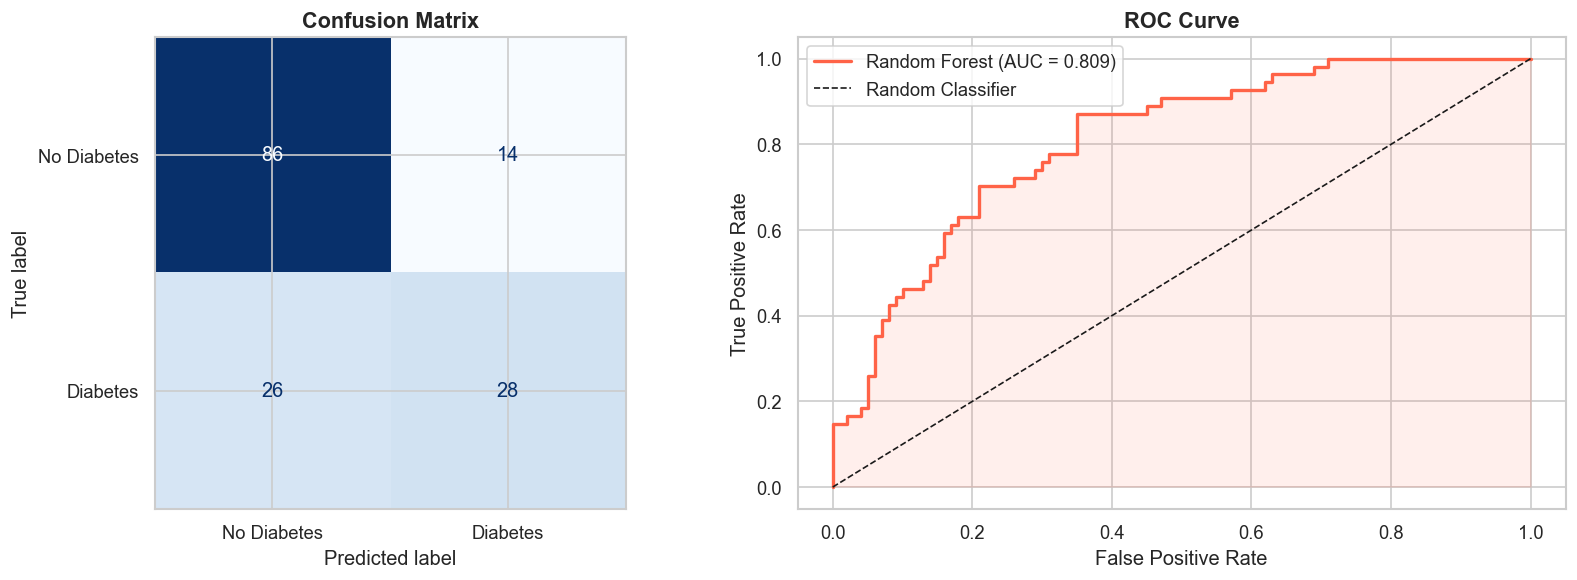

In [17]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
axes[1].plot(fpr, tpr, color='tomato', lw=2, label=f'Random Forest (AUC = {auc:.3f})')
axes[1].plot([0,1],[0,1],'k--', lw=1, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='tomato')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 9. Feature Importance

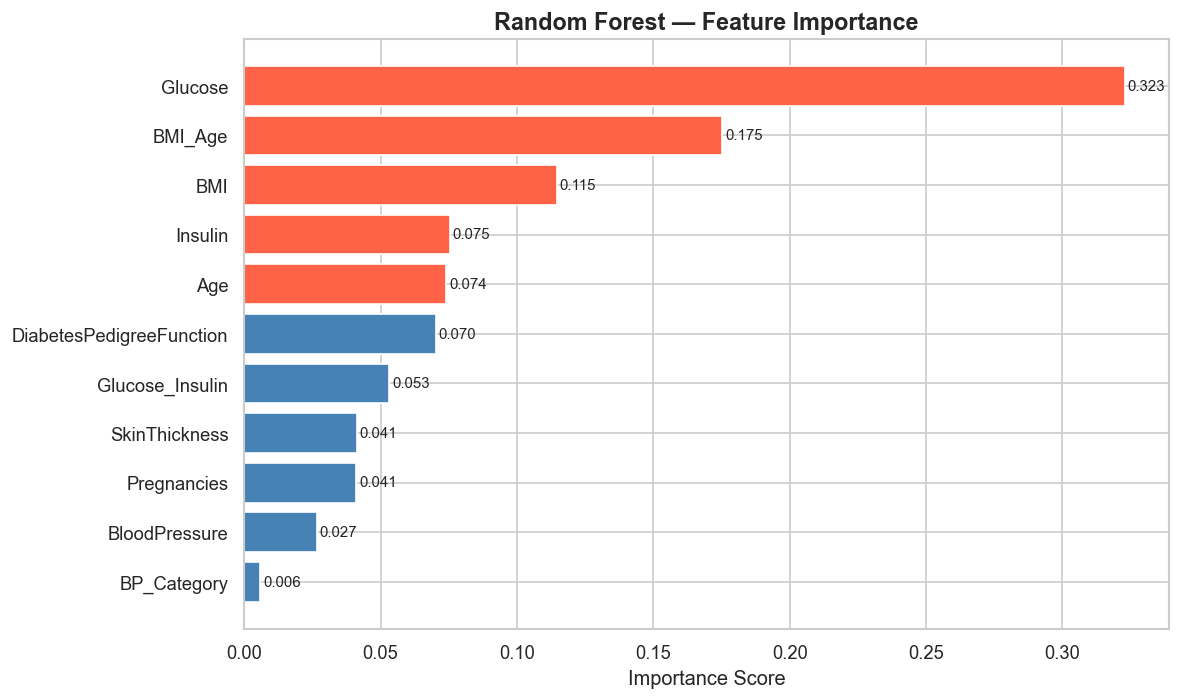


Top 5 Most Important Features:
Glucose    0.322855
BMI_Age    0.175292
BMI        0.114555
Insulin    0.075271
Age        0.074063
dtype: float64


In [18]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
colors = ['tomato' if v > importances_sorted.median() else 'steelblue' for v in importances_sorted]
bars = plt.barh(importances_sorted.index, importances_sorted.values, color=colors, edgecolor='white')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest — Feature Importance', fontsize=14, fontweight='bold')

for bar, val in zip(bars, importances_sorted.values):
    plt.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print('\nTop 5 Most Important Features:')
print(importances.sort_values(ascending=False).head())

In [19]:
import joblib

# Save the best model and scaler
joblib.dump(best_rf, "diabetes_prediction.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model saved as diabetes_model.pkl")
print("✅ Scaler saved as scaler.pkl")

✅ Model saved as diabetes_model.pkl
✅ Scaler saved as scaler.pkl
